# Прогнозирование температуры звезды

Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:  
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.  


Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.  
В базе обсерватории есть характеристики уже изученных 240 звёзд.

## Загрузка данных

Импортируем библиотеки с которыми будем работать

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import torch
import torch.nn as nn

from math import ceil, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None
torch.use_deterministic_algorithms(True)

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

Загрузим и прочитаем датасет

In [ ]:
df = pd.read_csv('/datasets/6_class.csv', sep=',' , index_col=0)

Выведем на экран первые 10 записей

In [ ]:
df.head(10)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
5,2840,0.000650,0.1100,16.98,0,Red
6,2637,0.000730,0.1270,17.22,0,Red
7,2600,0.000400,0.0960,17.40,0,Red
8,2650,0.000690,0.1100,17.45,0,Red
9,2700,0.000180,0.1300,16.05,0,Red


Ознакомимся детальнее с данными датасета

In [ ]:
df.describe(include = 'all')

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
count,240.000000,240.000000,240.000000,240.000000,240.000000,240
unique,NaN,NaN,NaN,NaN,NaN,19
top,NaN,NaN,NaN,NaN,NaN,Red
freq,NaN,NaN,NaN,NaN,NaN,112
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000,NaN
std,9552.425037,179432.244940,517.155763,10.532512,1.711394,NaN
min,1939.000000,0.000080,0.008400,-11.920000,0.000000,NaN
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000,NaN
50%,5776.000000,0.070500,0.762500,8.313000,2.500000,NaN
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000,NaN


Ознакомимся с типом данных датафрейма

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


### Вывод:  
 - В исходном датасете 240 строк, 6 столбцов;
 - Из исходного задания нам известно названия столбцов и характеристики:
     - Относительная светимость L/Lo — светимость звезды относительно Солнца (`тип. float64`);
     - Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца (`тип float64`);
     - Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды (`тип float64`);
     - Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа (`тип object`);
     - Тип звезды (`тип int64`)
         - Тип данных необходимо будет поменять на `object`;
     - Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах (`тип int64`).

## Предобработка и анализ данных

Посмотрим есть ли пропуски в данных

In [ ]:
df.isna().sum().to_frame()

,0
Temperature (K),0
Luminosity(L/Lo),0
Radius(R/Ro),0
Absolute magnitude(Mv),0
Star type,0
Star color,0


Пропусков не обнаружено.

Проверим на явные дубликаты

In [ ]:
df.duplicated().sum()

0

Явных дубликатов не обнаружено

Обозначим числовые и категориальные признаки: **num_cols** - числовые признаки, **cat_cols** - категориальные признаки, **target** - целевой признак

In [ ]:
num_cols = ['Luminosity(L/Lo)','Radius(R/Ro)','Absolute magnitude(Mv)']
cat_cols = ['Star type', 'Star color']
target = ['Temperature (K)']

Выведем уникальные значения в категориальных признаках

In [ ]:
df['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Узнаем сколько значений в столбце **Star color** Звёздный цвет (white, red, blue, yellow, yellow-orange и др.)

In [ ]:
df['Star color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Yellowish White         3
Blue white              3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
Blue                    1
Blue-White              1
Orange-Red              1
Blue white              1
White-Yellow            1
Yellowish               1
Name: Star color, dtype: int64

Ознакомимся визуально с распределением данных в столбце **Star color**

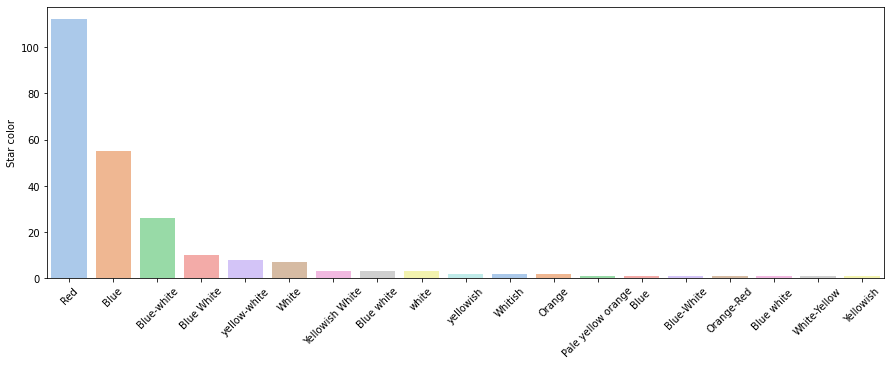

In [ ]:
stars_color = pd.DataFrame(df['Star color'].value_counts().sort_values(ascending=False))
plt.figure(figsize=(15,5))
ax = sns.barplot(x = stars_color.index, y = 'Star color' , data = stars_color, palette='pastel')
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

Вывод:  
 - Есть опечатки в названиях (`Blue-white` и `Blue White`),
 - Некоторые данные присутствуют в единичном экземпляре (`Orange-Red 1, Blue-White 1, Blue 1, Blue white 1, White-Yellow 1, Yellowish 1, Pale yellow orange 1`),
 - Возникновение некоторых названий в столбце **Star color** Звёздный цвет объяснить не представляется возможным, по классификации предлагается перераспределить значения в пределах следующих данные: `Blue, Blue_white, White, Yellow_white, Yellow, Orange, Red`.

Напишем функцию перераспределения к какому цвету звезда относится

In [ ]:
def star_color(x):
    if x > 30000:
        return 'Blue'
    elif 30000 >= x > 10000:
        return 'Blue_white'
    elif 10000 >= x > 7400:
        return 'White'
    elif 7400 >= x > 6000:
        return 'Yellow_white'
    elif 6000 >= x > 5000:
        return 'Yellow'
    elif 5000 >= x > 3800:
        return 'Orange'
    else:
        return 'Red'

df['Star color'] = df['Temperature (K)'].apply(star_color)

Посмотрим, как сработал функция

In [ ]:
df['Star color'].value_counts()

Red             109
Blue_white       76
White            21
Blue             14
Yellow_white      7
Orange            7
Yellow            6
Name: Star color, dtype: int64

Посмотрим новые данные на графике

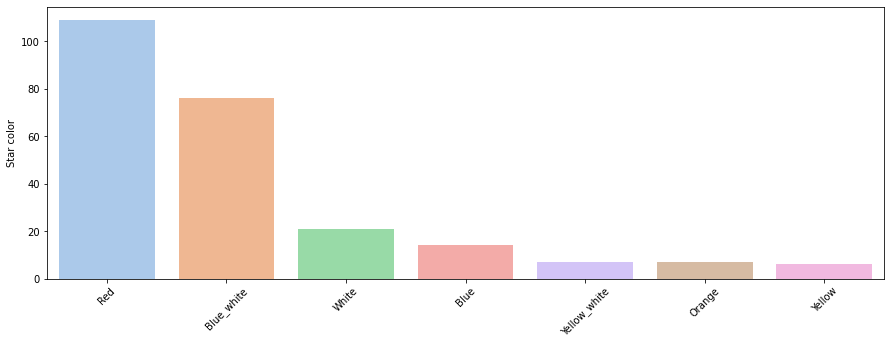

In [ ]:
stars_color = pd.DataFrame(df['Star color'].value_counts().sort_values(ascending=False))
plt.figure(figsize=(15,5))
ax = sns.barplot(x = stars_color.index, y = 'Star color' , data = stars_color, palette='pastel')
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

Поработаем со столбцом **Star type**

Поменяем типа данных на `object`

In [ ]:
df['Star type'] = df['Star type'].astype(dtype='object')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    object 
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 13.1+ KB


Посмотрим на уникальные значения **Star type**

In [ ]:
df['Star type'].unique()

array([0, 1, 2, 3, 4, 5], dtype=object)

Посмотрим как это выглядит на графике

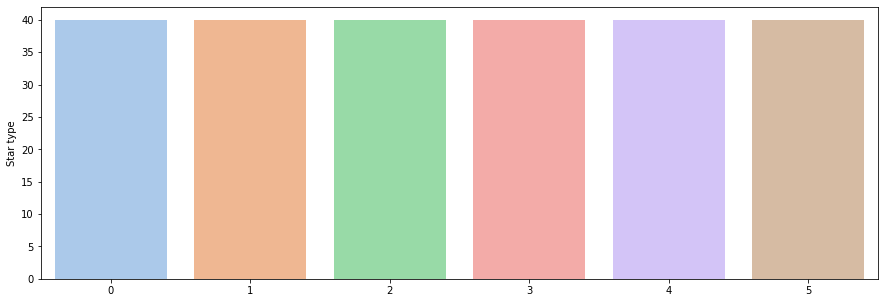

In [ ]:
stars_types = pd.DataFrame(df['Star type'].value_counts().sort_values(ascending=False))
plt.figure(figsize=(15,5))
ax = sns.barplot(x = stars_types.index, y = 'Star type' , data = stars_types, palette='pastel')

Вывод: данные сбалансированы

Посмотрим, есть ли линейная зависимость в данных, посмотрим на корреляцию

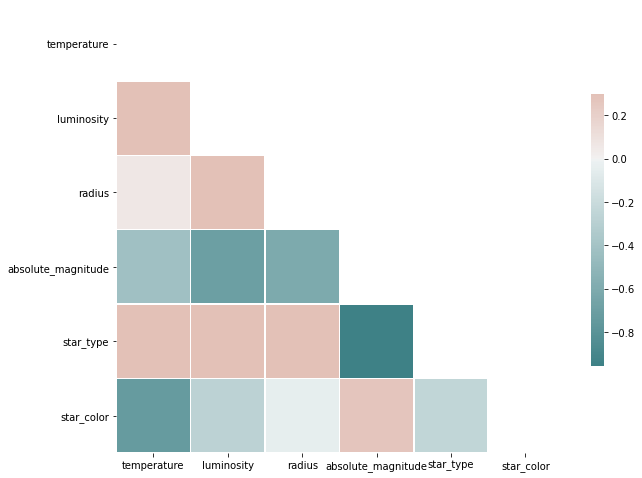

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
temperature,1.000000,0.393404,0.064216,-0.420261,0.411129,-0.738245
luminosity,0.393404,1.000000,0.526516,-0.692619,0.676845,-0.274398
radius,0.064216,0.526516,1.000000,-0.608728,0.660975,-0.047392
absolute_magnitude,-0.420261,-0.692619,-0.608728,1.000000,-0.955276,0.272803
star_type,0.411129,0.676845,0.660975,-0.955276,1.000000,-0.241878
star_color,-0.738245,-0.274398,-0.047392,0.272803,-0.241878,1.000000


In [ ]:
stars_data = {
    'temperature': df['Temperature (K)'],
    'luminosity': df['Luminosity(L/Lo)'],
    'radius': df['Radius(R/Ro)'],
    'absolute_magnitude': df['Absolute magnitude(Mv)'],
    'star_type': df['Star type'],
    'star_color': df['Star color']
}
stars_data = pd.DataFrame.from_dict(stars_data)
stars_data['star_type'] = stars_data['star_type'].astype('category').cat.codes
stars_data['star_color'] = stars_data['star_color'].astype('category').cat.codes

corr = stars_data.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(200, 21, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()
corr

Вывод: есть слабая корреляция между:  
 - радиусом и температурой;
 - типом звезды и цветом звезды;
 - цветом звезды и радиусом

Изучим таргет, столбец **Temperature (K)**

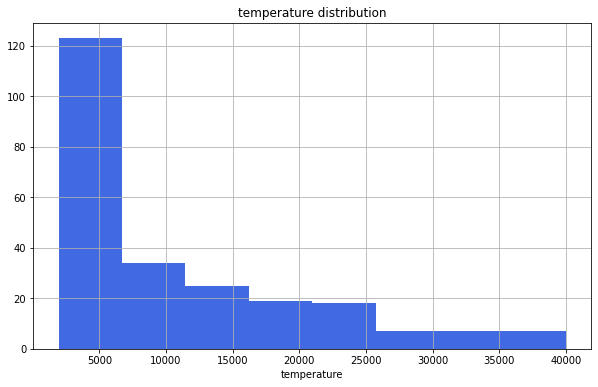

In [ ]:
plt.figure(figsize=[10, 6])
df['Temperature (K)'].hist(bins=8, color='royalblue')
plt.xlabel('temperature')
plt.title('temperature distribution')
plt.show()

Таргет распределен экспоненциально

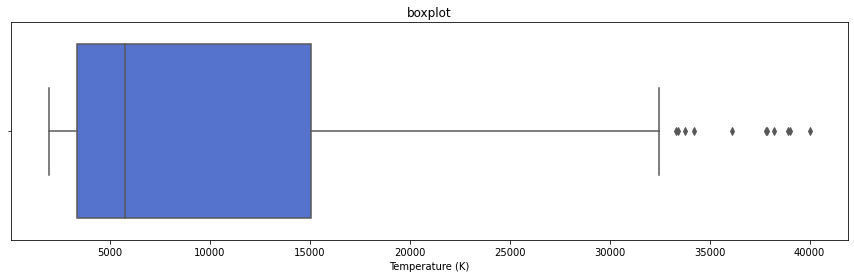

In [ ]:
plt.figure(figsize=[15,4])
sns.boxplot(x=df['Temperature (K)'], color='royalblue')
plt.title('boxplot')
plt.show()

Изучим столбец **Luminosity(L/Lo)**

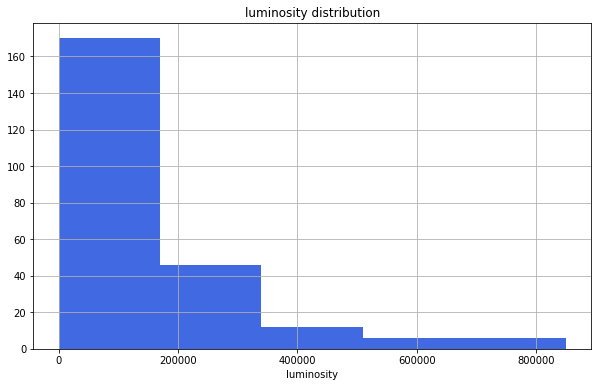

In [ ]:
plt.figure(figsize=[10, 6])
df['Luminosity(L/Lo)'].hist(bins=5, color='royalblue')
plt.xlabel('luminosity')
plt.title('luminosity distribution')
plt.show()

Колонка **Luminosity(L/Lo)** также распределена экспоненциально

Изучим колонку **Radius(R/Ro)**

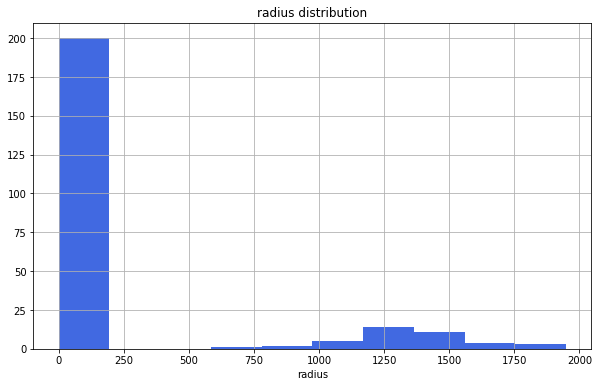

In [ ]:
plt.figure(figsize=[10, 6])
df['Radius(R/Ro)'].hist(color='royalblue')
plt.xlabel('radius')
plt.title('radius distribution')
plt.show()

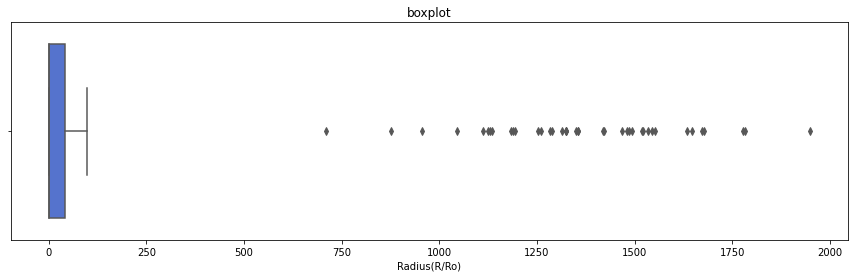

In [ ]:
plt.figure(figsize=[15,4])
sns.boxplot(x=df['Radius(R/Ro)'], color='royalblue')
plt.title('boxplot')
plt.show()

Много выбросов, но мы работаем с темой астрономии, в данном случае выбросы удалять не будем

Изучим колонку **Absolute magnitude(Mv)**

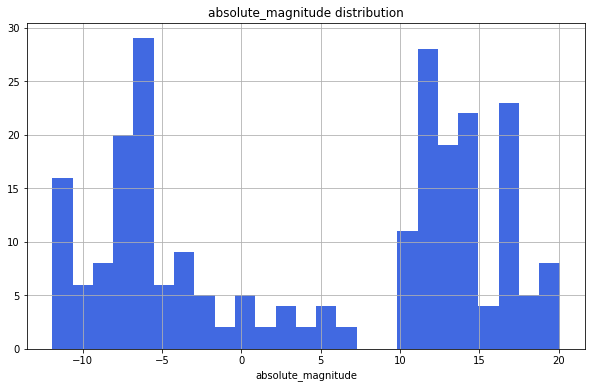

In [ ]:
plt.figure(figsize=[10, 6])
df['Absolute magnitude(Mv)'].hist(bins=25, color='royalblue')
plt.xlabel('absolute_magnitude')
plt.title('absolute_magnitude distribution')
plt.show()

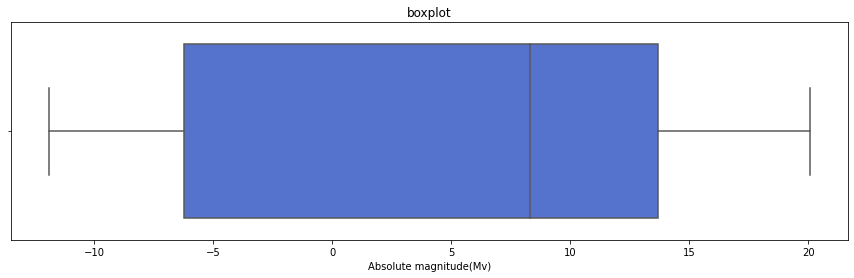

In [ ]:
plt.figure(figsize=[15,4])
sns.boxplot(x=df['Absolute magnitude(Mv)'], color='royalblue')
plt.title('boxplot')
plt.show()

### Обработка при помощи OHE и StandartScaler

In [ ]:
X = df.drop(target, axis = 1).copy()
y = df[target].copy()

Разделим выборку на тестовую и тренировочную

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3214)

for x,y,z in zip((y_train, y_test),(X_train, X_test), ('тренировочной', 'тестовой')):
    print(f'В {z} выборке, размеры матрицы признаков  = {y.shape}, целевого признака = {x.shape}')

В тренировочной выборке, размеры матрицы признаков  = (192, 5), целевого признака = (192, 1)
В тестовой выборке, размеры матрицы признаков  = (48, 5), целевого признака = (48, 1)


In [ ]:
for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(drop=True, inplace=True)

Работа с категориальными признаками методом OHE

In [ ]:
OHE = OneHotEncoder(sparse_output=False, drop = 'first', handle_unknown = 'error')

X_train_cat = pd.DataFrame(OHE.fit_transform(X_train.loc[:,cat_cols]))
X_train_cat.columns = OHE.get_feature_names_out(cat_cols)
X_train.drop(cat_cols, axis = 1, inplace = True)
X_train = pd.concat([X_train, X_train_cat], axis = 1)

X_test_cat = pd.DataFrame(OHE.transform(X_test.loc[:,cat_cols]))
X_test_cat.columns = OHE.get_feature_names_out(cat_cols)
X_test.drop(cat_cols, axis = 1, inplace = True)
X_test = pd.concat([X_test, X_test_cat], axis = 1)

Масштабирование числовых признаков

In [ ]:
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

Выведем на экран тренировочный набор данных после обработки

In [ ]:
X_train.head()

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star color_Blue_white,Star color_Orange,Star color_Red,Star color_White,Star color_Yellow,Star color_Yellow_white
0,-0.627498,-0.440475,-0.145987,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.496468,2.230756,-1.387146,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.627506,-0.442579,1.477650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.627506,-0.442030,0.756244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.627506,-0.442717,0.754351,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Вывод:  
 - Мы изучили датафрейм, пропусков не обнаружено
 - Явных дубликатов не обнаружено
 - Были опечатки в названиях в столбце Star color, исправлены
 - Перераспределили значения в пределах следующих данные: Blue, Blue_white, White, Yellow_white, Yellow, Orange, Red.
 - Изменили тип данных в в столбце Star type на `object'
    - В данных есть корреляция между:
        - радиусом и температурой;
        - типом звезды и цветом звезды;
        - цветом звезды и радиусом  
        
- Кодировали данные при помощи OHE, масштабировали числовые признаки

## Построение базовой нейронной сети

Переведём наши данные к тензорам

In [ ]:
X_train = torch.FloatTensor(X_train.values)
X_test  = torch.FloatTensor(X_test.values)
y_train  = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

Настроим количество нейронов на слоях сети

In [ ]:
n_in_neurons = 14
n_hidden_neurons_1 = 50
n_hidden_neurons_2 = 20
n_out_neurons = 1

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

In [ ]:
net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons) #модель
loss=nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer1 = torch.optim.RMSprop(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-2)

Функция для кросс-валидации нейронной сети

In [ ]:
def cross_vall_score(model, X_train, y_train, optim, num_epochs=250, batch_size=6, k=4, loss=nn.MSELoss()):
    num_batches = ceil(len(X_train)/batch_size) # количество батчей
    num_val_samples = len(X_train)//k # размер валидационной выборки
    all_scores = []

    for i in range(k):
        #разбиваем на валидационную и тренировочную выборку
        print('processing fold #', i+1, end='  ')

        #обнуляем веса нейронной сети
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        #валидационная выборка
        val_data = X_train[i*num_val_samples: (i+1)*num_val_samples]
        val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]

        #тренировочная выборка
        partial_train_data = np.concatenate([X_train[:i*num_val_samples], X_train[(i+1)*num_val_samples:]], axis = 0)
        partial_train_targets = np.concatenate([y_train[:i*num_val_samples], y_train[(i+1)*num_val_samples:]], axis = 0)

        #приводим наши данные к формату FloatTensor
        val_data = torch.FloatTensor(val_data)
        val_targets = torch.FloatTensor(val_targets)
        partial_train_data = torch.FloatTensor(partial_train_data)
        partial_train_targets = torch.FloatTensor(partial_train_targets)

        for epoch in range(num_epochs):
            #создаем случайную перестановку индексов для каждой эпохи
            order = np.random.permutation(len(partial_train_data))
            for batch_idx in range(num_batches):
                start_index = batch_idx * batch_size #стартовый индекс батча
                optim.zero_grad() #обнуляем градиаенты

                #извлекаем батч
                batch_indexes = order[start_index:start_index+batch_size]
                X_batch = partial_train_data[batch_indexes]
                y_batch = partial_train_targets[batch_indexes]

                preds = net.forward(X_batch).flatten() #получаем предсказание
                loss_value = loss(preds, y_batch.flatten()) #высчитываем ошибку
                loss_value.backward()
                optim.step()

            if epoch == num_epochs-1:
                model.eval()
                val_preds = model.forward(val_data)
                RMSE_loss = torch.sqrt(loss(val_targets, val_preds))
                all_scores.append(RMSE_loss)
                print('RMSE метрика =', float(RMSE_loss))
    print('Средняя RMSE метрика =', int(sum(all_scores)/len(all_scores)),  '\n')
    return

In [ ]:
x = [optimizer, optimizer1, optimizer2, optimizer3]

for i in x:
    print(i)
    cross_vall_score(net, X_train, y_train, i)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 6077.55224609375
processing fold # 2  RMSE метрика = 5214.10009765625
processing fold # 3  RMSE метрика = 5345.73974609375
processing fold # 4  RMSE метрика = 5070.201171875
Средняя RMSE метрика = 5426 

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 6231.0546875
processing fold # 2  RMSE метрика = 6566.34619140625
processing fold # 3  RMSE метрика = 5826.9384765625
processing fold # 4  RMSE метрика = 6129.68310546875
Средняя RMSE метрика = 6188 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 3433.72900390625
processing fold # 2  RMSE метрика = 3760.66259765625
processing fold # 3  RMSE метрика = 3670.81811523

Лучше всего себя показала оптимизация Adamax с шагом сходимости в 0.01

Напишем функцию которая обучает нейронную сеть батчами с заданным количеством эпох

In [ ]:
def neiron(model, X_train, y_train, optim, num_epochs = 250, batch_size = 6):
    num_batches = ceil(len(X_train)/batch_size)
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optim.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size] #индексы объектов текущего обатча
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = model.forward(X_batch).flatten()
            loss_value = loss(preds, y_batch.flatten())
            loss_value.backward()
            optim.step()
    return  model

Обучим модель с заданными параметрами

In [ ]:
net = neiron(net, X_train, y_train, optimizer3)

In [ ]:
net.eval()
test_preds = net.forward(X_test)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(y_test, test_preds))))

RMSE нейронной сети на тестовой выборке =  3528


По заданию, необходимо выведите метрику RMSE и график «Факт — прогноз». Метрика RMSE не должна превышать 4500. Это услове удовлетворяется.  
Построим график

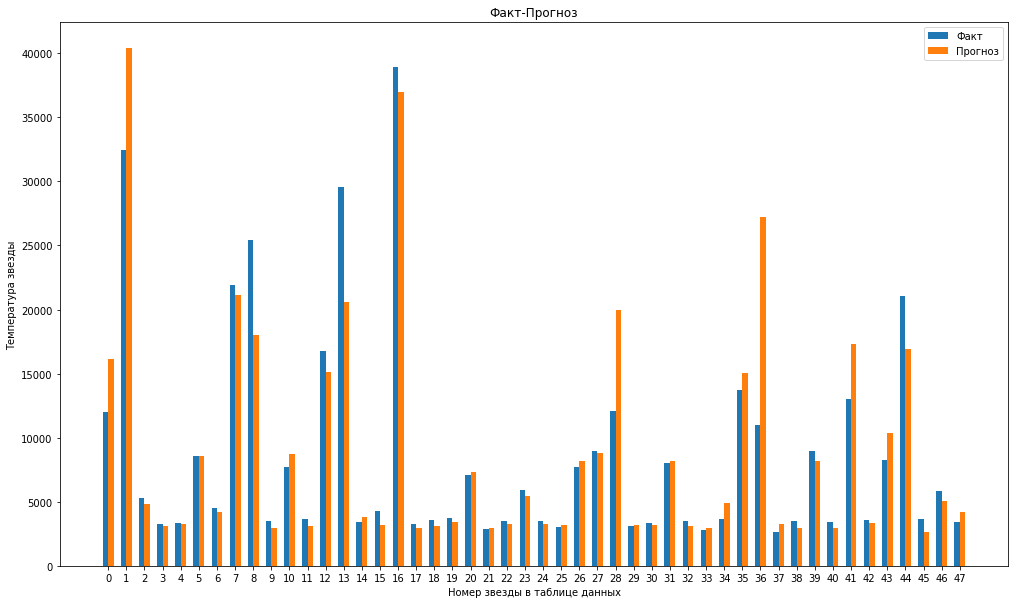

In [ ]:
def vizualization(target, preds, width = 0.3):
    '''Визуализирует предсказания нейронной сети на тестовой выборке'''
    y1 = target.numpy().reshape([-1])
    y2 = preds.reshape([-1]).detach().numpy()
    x = np.arange(len(y1))

    fig,ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y1, width, label = 'Факт')
    rects2 = ax.bar(x + width/2, y2, width, label = 'Прогноз')
    ax.set_title('Факт-Прогноз')
    ax.set_xticks(x)
    ax.set_xlabel('Номер звезды в таблице данных')
    ax.set_ylabel('Температура звезды')
    fig.set_figwidth(17)
    fig.set_figheight(10)
    ax.legend();

vizualization(y_test, test_preds)

Из графика видно что нейронная сеть хорошо предсказывает температуру звезды, хотя есть и исключения, номера звезды в таблице 28, 36.

## Улучшение нейронной сети

Применим «dropout» и BatchNorm1d. Посмотрим, как повлияет на результаты обучения нейронной сети, в лучшую сторону или нет.

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp2 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

In [ ]:
net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
loss = nn.MSELoss()

optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3)
optimizer1 = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-2)

In [ ]:
x = [optimizer, optimizer1, optimizer2, optimizer3]

for i in x:
    print(i)
    cross_vall_score(net, X_train, y_train, i)

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 14378.7197265625
processing fold # 2  RMSE метрика = 5126.19921875
processing fold # 3  RMSE метрика = 5167.8134765625
processing fold # 4  RMSE метрика = 4627.86669921875
Средняя RMSE метрика = 7325 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 4903.9033203125
processing fold # 2  RMSE метрика = 3036.385498046875
processing fold # 3  RMSE метрика = 3340.2373046875
processing fold # 4  RMSE метрика = 3899.6953125
Средняя RMSE метрика = 3795 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 3883.509033203125
processing fold # 2  RMSE метрика = 4218.787109375
processing fold # 3  RMSE метрика = 3245.45166015625

In [ ]:
net = neiron(net, X_train, y_train, optimizer3)

In [ ]:
net.eval()
test_preds = net.forward(X_test)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(y_test, test_preds))))

RMSE нейронной сети на тестовой выборке =  3906


Построим график «Факт — Прогноз» улучшенной нейронной сети, где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах.

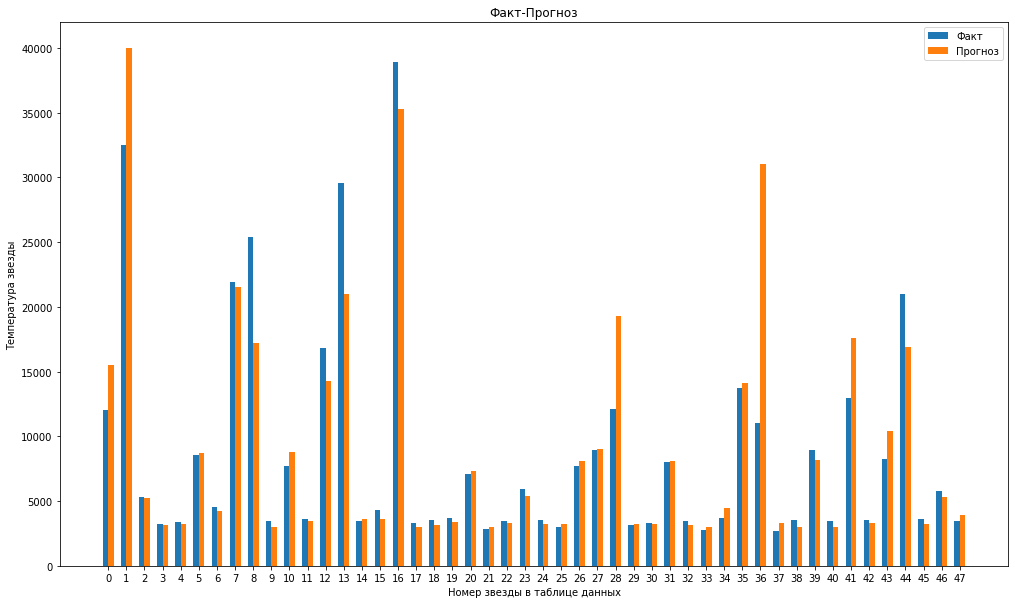

In [ ]:
vizualization(y_test, test_preds)

## Выводы

По проекту, задание было от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. С внедрением технологии машинного обучения для предсказания температуры звёзд, метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

Данные были загружены, произведен исследовательский анализ данных. Где необходимо тип данных был переведен в нужный. В датасете пропуски не обнаружены. Явных дубликатов не было. Опечатки в названиях в столбцах исправлены. Перераспределили значения в столбце Звёздный цвет (white, red, blue, yellow, yellow-orange и др.). Обнаружили слабую корреляцию между радиусом и температурой, типом звезды и цветом звезды, цветом звезды и радиусом. Кодировали данные при помощи OHE, масштабировали числовые признаки.

Была разработана нейронная сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

Первоначально построенная базовая нейронная сеть показала RMSE на тестовой выборке =  3528. Улучшенная модель нейронной сети имела RMSE на тестовой выборке = 3906. Таким образом применение «dropout» и BatchNorm1d на улучшенной модели оказало негативный эффект.